## Problem Definition

In [71]:
import numpy as np
import gym
from gym import spaces
import torch
import random
from tqdm import tqdm

from typing import List, Union

RANDOM_SEED = 42
SIGMA_NOISE = 0.01
torch.manual_seed(RANDOM_SEED)

from constants import DTYPE, FIG_HEIGHT, DPI, LABEL_FONT_SIZE

class CircleRotationEnvSameStart(gym.Env):

    def __init__(self,
                 s_goals: List[np.array],
                 seed: int,
                 q_x=1,
                 q_y=1,
                 sigma_noise=SIGMA_NOISE):
        
        self.seed(seed)

        # Define system dynamics
        self.q_x = q_x
        self.q_y = q_y

        # State and action spaces
        self.state_dim = 2
        self.action_dim = 2
        self.sigma_noise = sigma_noise
        self.observation_space = spaces.Box(low=-2.0, high=2.0, shape=(3,), dtype=np.float32)
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(2,), dtype=np.float32)

    
        self.Q = np.array([[self.q_x, 0.0],
                      [0.0, self.q_y]])

        # Define goal state
        self.goal_states = s_goals
        self.goal_state = random.choice(self.goal_states).copy()

        # Define initial state
        self._point = np.array([0.0, 0.0], dtype=np.float32)
        dist = np.linalg.norm(self._point - self.goal_state)
        self.s = np.concatenate([self._point, (dist,)])

        self.episode_length = 100
        self.step_count = 0


    def reset(self):

        '''
        Reset the system to its initial state. Samples a new task.
        '''
        self._point = np.zeros_like(self.goal_state)
        self.goal_state = random.choice(self.goal_states).copy()

        dist = np.linalg.norm(self._point - self.goal_state)
        self.s = np.concatenate([self._point,
                                (dist, )])
        self.step_count = 0
        return self.s
    

    def step(self, u):

        '''
        Step the system forward by one time step from state s with control input u. Returns the next state, the cost and whether the episode is done.
        '''

        # Compute reward.
        dist = np.linalg.norm(self._point - self.goal_state)
        reward = -dist
        self.step_count += 1

        # Check if episode is done.
        if self.step_count == self.episode_length-1 or np.allclose(self._point, self.goal_state, atol=0.1*np.sqrt(2)):
            done = True
            self.step_count = 0
        else:
            done = False

        # Compute next state
        self._point = self._point + u
        self._point += np.random.normal(loc=0, scale=self.sigma_noise, size=2) if self.sigma_noise > 0 else 0
        self.s = np.concatenate([self._point, (dist,)])

        return self.s, reward, done, {}
    

    def seed(self, seed=None):
        np.random.seed(seed)
        return [seed]

In [72]:
def generate_circle_points(N):
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    x = np.cos(angles)
    y = np.sin(angles)
    points = np.stack((x, y), axis=1)
    return points

# Example
N_TOTAL_TASKS = 9
IDXS_TRAIN_TASKS = [0] #only use one task as otherwise environment is too simple and benefit of symmetry is less clear
IDX_TEST_TASKS = set(range(N_TOTAL_TASKS)) - set(IDXS_TRAIN_TASKS)
goal_positions_all = generate_circle_points(N_TOTAL_TASKS)

goal_positions_train = [goal_positions_all[idx] for idx in IDXS_TRAIN_TASKS]
goal_positions_test = [goal_positions_all[idx] for idx in IDX_TEST_TASKS]

print("Goal Positions Train:")
for pos in goal_positions_train:
    print(pos.round(2))

print("\nGoal Positions Test:")
for pos in goal_positions_test:
    print(pos.round(2))

Goal Positions Train:
[1. 0.]

Goal Positions Test:
[0.77 0.64]
[0.17 0.98]
[-0.5   0.87]
[-0.94  0.34]
[-0.94 -0.34]
[-0.5  -0.87]
[ 0.17 -0.98]
[ 0.77 -0.64]


In [73]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
import os

# Make the environment
env = CircleRotationEnvSameStart(s_goals=goal_positions_train, seed=RANDOM_SEED)

# Optionally wrap in a vectorized env (recommended for SB3)
vec_env = make_vec_env(lambda: env, n_envs=os.cpu_count(), seed=RANDOM_SEED)

# Create the model
model = SAC("MlpPolicy", vec_env, verbose=1, seed=RANDOM_SEED)

# Train the model
model.learn(total_timesteps=150_000)

/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9        |
|    ep_rew_mean     | -10.3    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 600      |
|    time_elapsed    | 0        |
|    total_timesteps | 396      |
| train/             |          |
|    actor_loss      | -1.44    |
|    critic_loss     | 0.125    |
|    ent_coef        | 0.993    |
|    ent_coef_loss   | -0.0251  |
|    learning_rate   | 0.0003   |
|    n_updates       | 26       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.8     |
|    ep_rew_mean     | -16.2    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 496      |
|    time_elapsed    | 1        |
|    total_timesteps | 792      |
| train/             |          |
|    actor_loss      | -1.63    |
|    critic_loss     | 0.116   

## Roll-Out Policy on New Tasks

In [74]:
import matplotlib.pyplot as plt

def sample_traj_of_env(environment, trained_model):
    n_steps = 100
    obs = environment.reset()
    trajectory = []
    rewards = []
    actions = []
    trajectory.append(obs.copy())

    for _ in range(n_steps):
        action, _ = trained_model.predict(obs, deterministic=True)
        obs, reward, done, _ = environment.step(action)

        actions.append(action)
        trajectory.append(obs.copy())
        rewards.append(reward)

        if done:
            break

    trajectory = np.array(trajectory)
    rewards = np.array(rewards)
    actions = np.array(actions)

    return trajectory, actions, rewards

trajs_all_tasks_train = []
trajs_all_tasks_test = []
actions_all_tasks_train = []
actions_all_tasks_test = []
RANDOM_SEEDS_EVALUATION = np.random.choice(np.arange(10_000), size=N_TOTAL_TASKS, replace=False)

for idx_goal_position, goal_position in enumerate(goal_positions_all):
    test_env = CircleRotationEnvSameStart(s_goals=[goal_position], seed=RANDOM_SEEDS_EVALUATION[idx_goal_position])
    traj, actions, rewards = sample_traj_of_env(test_env, model)
    if any(np.array_equal(goal_position, s_inits) for s_inits in goal_positions_train):
        trajs_all_tasks_train.append(traj)
        actions_all_tasks_train.append(actions)
    else:
        trajs_all_tasks_test.append(traj)
        actions_all_tasks_test.append(actions)        
    del test_env

In [75]:
import matplotlib.pyplot as plt

def plot_rollouts_on_circle(train_trajectories,
                             test_trajectories,
                             train_goal_locations,
                             test_goal_locations,
                             idx_label_test=3,
                             legend: bool=False,
                             savepath: str=None):
    """Plots trajectories from the different tasks on the circle."""

    # 1. Set fixed figure size (square)
    fig, ax = plt.subplots(figsize=(FIG_HEIGHT, FIG_HEIGHT))

    use_label_train: bool = True
    label=None
    cmap = plt.get_cmap('Reds')

    num_trajs = len(test_trajectories)
    
    # Train distribution
    circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--', linewidth=2, label=r'$p(\mathcal{T})$', zorder=3, alpha=0.3)
    ax.add_artist(circle)

    for idx_traj, test_traj in enumerate(test_trajectories):
        color = cmap(0.5 + 0.5 * idx_traj / max(1, num_trajs - 1))
        if idx_traj == idx_label_test:
            label = "Test"
            ax.plot(test_traj[:-1,0], test_traj[:-1,1], marker="x", color=color, alpha=1, label=label)
        else:
            ax.plot(test_traj[:-1,0], test_traj[:-1,1], marker="x", color=color, alpha=1, label=None)
        ax.scatter(test_goal_locations[idx_traj][0], test_goal_locations[idx_traj][1], color=color, marker="X", s=500)

    for idx_traj, train_traj in enumerate(train_trajectories):
        if use_label_train:
            label="Train"
            use_label_train=False
            ax.plot(train_traj[:-1,0], train_traj[:-1,1], marker="x", color="black", alpha=1, label=label)
        else:
            ax.plot(train_traj[:-1,0], train_traj[:-1,1], marker="x", color="black", alpha=1, label=None)
        ax.scatter(train_goal_locations[idx_traj][0], train_goal_locations[idx_traj][1], color="black", marker="X", s=500)


    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.axis('off')

    if legend:
        ax.legend(ncols=4, loc='upper center', bbox_to_anchor=(0.5, 0.15), fontsize=LABEL_FONT_SIZE)

    # 2. Save figure
    if savepath:
        fig.savefig(savepath, bbox_inches='tight', pad_inches=0.05, dpi=DPI)

    plt.show()

    plt.close(fig)


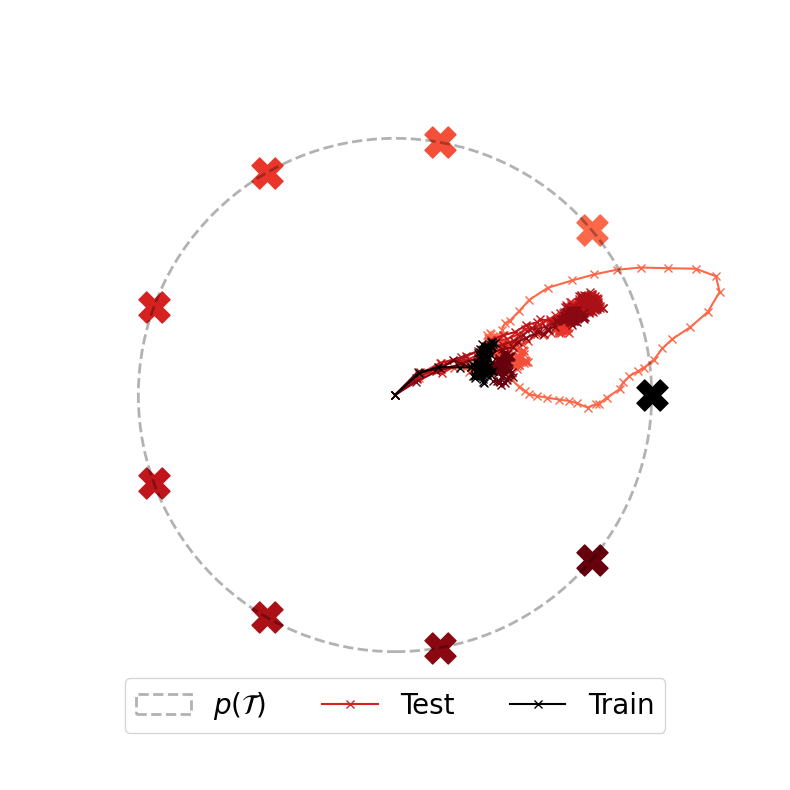

In [76]:
plot_rollouts_on_circle(train_trajectories=trajs_all_tasks_train,
                        test_trajectories=trajs_all_tasks_test,
                        train_goal_locations=goal_positions_train,
                        test_goal_locations=goal_positions_test,
                        legend=True,
                        savepath=None
                        # savepath="trajs_equ_MDP"
                        )

## Equivariant Policy (with ground-truth task encodings)

- No Encoder for symmetry yet

In [168]:
Lg = lambda theta : np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Kg = lambda theta : np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) #Runs counter-clockwise! Not the same as Lg

def sample_traj_of_env_via_sym(task, base_policy, Kg, Lg):
    """Rolls out a base policy in a new task via equivariance."""
    Kg_inv = np.linalg.inv(Kg)
    Lg_inv = np.linalg.inv(Lg)

    trajectory = []
    rewards = []
    actions = []

    n_steps = 100
    obs_tilde = task.reset()
    trajectory.append(obs_tilde.copy())
    obs_base = Lg_inv @ obs_tilde

    for _ in range(n_steps):
        action_base, _ = base_policy.predict(obs_base, deterministic=True)
        action_tilde = Kg_inv @ action_base
        obs_tilde, reward, done, _ = task.step(action_tilde)

        obs_base = Lg_inv @ obs_tilde

        actions.append(action_tilde)
        trajectory.append(obs_tilde.copy())
        rewards.append(reward)

        if done:
            break  # end the rollout

    return np.array(trajectory)


trajs_all_tasks_train_equ = []
trajs_all_tasks_test_equ = []
actions_all_tasks_train_equ = []
actions_all_tasks_test_equ = []
lgs_ground_truth = []

for task_idx, start_position in enumerate(start_positions_all):
    test_env = CircleRotationEnv(s_inits=[start_position], seed=RANDOM_SEED)
    g_action = task_idx*2*np.pi/N_TOTAL_TASKS
    Kg_test_task = Kg(g_action)
    Lg_test_task = Lg(g_action)
    lgs_ground_truth.append(Lg_test_task)

    traj_equ = sample_traj_of_env_via_sym(task=test_env, base_policy=model, Kg=Kg_test_task, Lg=Lg_test_task)

    if any(np.array_equal(start_position, s_inits) for s_inits in start_positions_train):
        trajs_all_tasks_train_equ.append(traj_equ)
    else:
        trajs_all_tasks_test_equ.append(traj_equ)
    del test_env

In [169]:
plot_rollouts_on_circle(train_trajectories=trajs_all_tasks_train_equ,
                        test_trajectories=trajs_all_tasks_test_equ,
                        legend=False,
                        savepath="trajs_equivar_policy_groundtruth_task")